In [1]:
import pyarabic.araby as araby
from tashaphyne.stemming import ArabicLightStemmer
import string
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import stanza
import nltk
import spacy
import qalsadi.lemmatizer as lem
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer


C:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### I- Import data from MongoDB :

In [2]:
# Connect to MongoDB
client = pymongo.MongoClient('localhost', 27017)
db = client['aljarida24']
collection = db['articles']

# get content from MongoDB
cursor = collection.find()
# Define a counter to keep track of the number of contents processed
count = 0

# Assuming you have already defined the 'cursor' object
for document in cursor:
    if count >= 2:
        break  # Exit the loop if we've processed two contents
    content = document.get('paragraphs')
    normalized_text = content.encode('utf-8')
    count=count+1

    

In [51]:
content

'طالب نواب المعارضة البرلمانية، بالكشف عن سبل تيسير الحصول على الدعم الاجتماعي المباشر، بعد ظهور عدد من الاشكاليات.  ووجه إدريس السنتيسي، رئيس الفريق الحركي بمجلس النواب، فوزي لقجع، الوزير المنتدب المكلف بالميزانية، سؤالا كتابيا مفاده سحب الدعم المباشر من عدد من المواطنين بعد شروعهم في الاستفادة.  وأكد السنتيسي في سؤاله أن العديد من المواطنات والمواطنين، فوجئوا بسحب الدعم المباشر ومعها نظام أمو تضامن بعد الشروع في الاستفادة منذ ثلاثة أشهر، الأمر الذي أثار امتعاض الفئات المعنية التي تقرر إبعادها عن هذا البرنامج بمبرر ارتفاع مؤشرهم الاجتماعي، رغم أنه لا يمكن أن تتغير وضعيتهم الاجتماعية والاقتصادية في هذا الظرف الوجيز.  وساءل رئيس الفريق الحركي بمجلس النواب، الوزير لقجع عن حقيقة هذا الإجراء وأسبابه ودوافعه وعدد المعنيين به وكذا انعكاساته الاجتماعية، لاسيما أن هؤلاء الأشخاص لا قدرة لهم على الانخراط في نظام أمو الشامل للأشخاص القادرين على دفع الاشتراكات.  '

### III - Clean & Normalize Arabic Text

In [3]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى",'\n', '\t','"','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    # remove HTML TAG
    html = re.compile('[<،,()"".#*?>]')
    text = html.sub(r'',text)
    
    # Remove urls:
    url = re.compile('https?://\S+|www\.S+')
    text = url.sub(r'',text)
    
    # Remove email id:
    email = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+')
    text = email.sub(r'',text)
    
    # Remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    # Remove longation "EX : سلاممممم = سلامم"
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    # remove any leading and trailing whitespace characters    
    text = text.strip()
    return text
    
print(content)
print("-----------------------------------------------------------")
para = clean_str(content)
print(para)

طالب نواب المعارضة البرلمانية، بالكشف عن سبل تيسير الحصول على الدعم الاجتماعي المباشر، بعد ظهور عدد من الاشكاليات.  ووجه إدريس السنتيسي، رئيس الفريق الحركي بمجلس النواب، فوزي لقجع، الوزير المنتدب المكلف بالميزانية، سؤالا كتابيا مفاده سحب الدعم المباشر من عدد من المواطنين بعد شروعهم في الاستفادة.  وأكد السنتيسي في سؤاله أن العديد من المواطنات والمواطنين، فوجئوا بسحب الدعم المباشر ومعها نظام أمو تضامن بعد الشروع في الاستفادة منذ ثلاثة أشهر، الأمر الذي أثار امتعاض الفئات المعنية التي تقرر إبعادها عن هذا البرنامج بمبرر ارتفاع مؤشرهم الاجتماعي، رغم أنه لا يمكن أن تتغير وضعيتهم الاجتماعية والاقتصادية في هذا الظرف الوجيز.  وساءل رئيس الفريق الحركي بمجلس النواب، الوزير لقجع عن حقيقة هذا الإجراء وأسبابه ودوافعه وعدد المعنيين به وكذا انعكاساته الاجتماعية، لاسيما أن هؤلاء الأشخاص لا قدرة لهم على الانخراط في نظام أمو الشامل للأشخاص القادرين على دفع الاشتراكات.  
-----------------------------------------------------------
طالب نواب المعارضه البرلمانيه بالكشف عن سبل تيسير الحصول علي الدعم الاجتماعي 

<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:14: SyntaxWarning: invalid escape sequence '\w'
<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:14: SyntaxWarning: invalid escape sequence '\w'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_28024\242138973.py:10: SyntaxWarning: invalid escape sequence '\S'
  url = re.compile('https?://\S+|www\.S+')
C:\Users\lenovo\AppData\Local\Temp\ipykernel_28024\242138973.py:14: SyntaxWarning: invalid escape sequence '\w'
  email = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+')


### III - Tokenize text to sentences & deleting stop words

In [4]:

def tokenize(para):
 # Tokenize the text
 tokens = word_tokenize(para)

 # Filter tokens to keep only non-numeric ones
 filtered_tokens = [token for token in tokens if not token.isdigit()]

 # Regular expression pattern to match words starting with 'و'
 pattern = r'^و\w*'
    
 # Tokenize the words starting with 'و'
 custom_tokens = []
 for token in filtered_tokens:
    if re.match(pattern, token):
        custom_tokens.append('و')
        if len(token) > 1:
            custom_tokens.append(token[1:])
    else:
        custom_tokens.append(token)
 return custom_tokens

custom_tokens=tokenize(para)

tokens_sen = araby.sentence_tokenize(content)
print(custom_tokens)
print('---------------------------')
print(tokens_sen)



['طالب', 'نواب', 'المعارضه', 'البرلمانيه', 'بالكشف', 'عن', 'سبل', 'تيسير', 'الحصول', 'علي', 'الدعم', 'الاجتماعي', 'المباشر', 'بعد', 'ظهور', 'عدد', 'من', 'الاشكاليات', 'و', 'جه', 'ادريس', 'السنتيسي', 'رئيس', 'الفريق', 'الحركي', 'بمجلس', 'النواب', 'فوزي', 'لقجع', 'الوزير', 'المنتدب', 'المكلف', 'بالميزانيه', 'سؤالا', 'كتابيا', 'مفاده', 'سحب', 'الدعم', 'المباشر', 'من', 'عدد', 'من', 'المواطنين', 'بعد', 'شروعهم', 'في', 'الاستفاده', 'و', 'اكد', 'السنتيسي', 'في', 'سؤاله', 'ان', 'العديد', 'من', 'المواطنات', 'و', 'المواطنين', 'فوجئوا', 'بسحب', 'الدعم', 'المباشر', 'و', 'معها', 'نظام', 'امو', 'تضامن', 'بعد', 'الشروع', 'في', 'الاستفاده', 'منذ', 'ثلاثه', 'اشهر', 'الامر', 'الذي', 'اثار', 'امتعاض', 'الفئات', 'المعنيه', 'التي', 'تقرر', 'ابعادها', 'عن', 'هذا', 'البرنامج', 'بمبرر', 'ارتفاع', 'مؤشرهم', 'الاجتماعي', 'رغم', 'انه', 'لا', 'يمكن', 'ان', 'تتغير', 'و', 'ضعيتهم', 'الاجتماعيه', 'و', 'الاقتصاديه', 'في', 'هذا', 'الظرف', 'الوجيز', 'و', 'ساءل', 'رئيس', 'الفريق', 'الحركي', 'بمجلس', 'النواب', 'الوزير', 

In [5]:

def stop_words(custom_tokens,tokens_sen):
 # Load Arabic stopwords
 stop_words = set(stopwords.words('arabic'))
 # Filter out stop words
 filtered_words = [token for token in custom_tokens if not token in stop_words]
 filtered_sen = [''.join([x for x in re.split(r'(\W+)', sent) if x not in stop_words]) for sent in tokens_sen]

 return filtered_words,filtered_sen

filtered_words,filtered_sen= stop_words(custom_tokens,tokens_sen)
print("Filtered sentence:")
print(filtered_sen)
print("\nFiltered Tokens:")
print(filtered_words)

Filtered sentence:
['طالب نواب المعارضة البرلمانية،', 'بالكشف  سبل تيسير الحصول  الدعم الاجتماعي المباشر،', ' ظهور عدد  الاشكاليات.', 'ووجه إدريس السنتيسي،', 'رئيس الفريق الحركي بمجلس النواب،', 'فوزي لقجع،', 'الوزير المنتدب المكلف بالميزانية،', 'سؤالا كتابيا مفاده سحب الدعم المباشر  عدد  المواطنين  شروعهم  الاستفادة.', 'وأكد السنتيسي  سؤاله  العديد  المواطنات والمواطنين،', 'فوجئوا بسحب الدعم المباشر ومعها نظام أمو تضامن  الشروع  الاستفادة   أشهر،', 'الأمر  أثار امتعاض الفئات المعنية  تقرر إبعادها   البرنامج بمبرر ارتفاع مؤشرهم الاجتماعي،', 'رغم أنه  يمكن  تتغير وضعيتهم الاجتماعية والاقتصادية   الظرف الوجيز.', 'وساءل رئيس الفريق الحركي بمجلس النواب،', 'الوزير لقجع  حقيقة  الإجراء وأسبابه ودوافعه وعدد المعنيين  وكذا انعكاساته الاجتماعية،', '   الأشخاص  قدرة   الانخراط  نظام أمو الشامل للأشخاص القادرين  دفع الاشتراكات.', '']

Filtered Tokens:
['طالب', 'نواب', 'المعارضه', 'البرلمانيه', 'بالكشف', 'سبل', 'تيسير', 'الحصول', 'علي', 'الدعم', 'الاجتماعي', 'المباشر', 'ظهور', 'عدد', 'الاشكاليات', 

In [7]:
arb = ''')(+`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”،.”…“–ـ”.'''
eng = string.punctuation
punct = arb + eng
filtered_sen = [sent.translate(str.maketrans('', '', punct)) for sent in filtered_sen]


### IV - One hot encoding 

In [8]:
# Create the vocabulary
vocab = {}
count = 0
for sent in filtered_sen:
    for word in sent.split():
        if word not in vocab:
            count = count + 1
            vocab[word] = count
print('vocabulary :', vocab)

vocabulary : {'طالب': 1, 'نواب': 2, 'المعارضة': 3, 'البرلمانية': 4, 'بالكشف': 5, 'سبل': 6, 'تيسير': 7, 'الحصول': 8, 'الدعم': 9, 'الاجتماعي': 10, 'المباشر': 11, 'ظهور': 12, 'عدد': 13, 'الاشكاليات': 14, 'ووجه': 15, 'إدريس': 16, 'السنتيسي': 17, 'رئيس': 18, 'الفريق': 19, 'الحركي': 20, 'بمجلس': 21, 'النواب': 22, 'فوزي': 23, 'لقجع': 24, 'الوزير': 25, 'المنتدب': 26, 'المكلف': 27, 'بالميزانية': 28, 'سؤالا': 29, 'كتابيا': 30, 'مفاده': 31, 'سحب': 32, 'المواطنين': 33, 'شروعهم': 34, 'الاستفادة': 35, 'وأكد': 36, 'سؤاله': 37, 'العديد': 38, 'المواطنات': 39, 'والمواطنين': 40, 'فوجئوا': 41, 'بسحب': 42, 'ومعها': 43, 'نظام': 44, 'أمو': 45, 'تضامن': 46, 'الشروع': 47, 'أشهر': 48, 'الأمر': 49, 'أثار': 50, 'امتعاض': 51, 'الفئات': 52, 'المعنية': 53, 'تقرر': 54, 'إبعادها': 55, 'البرنامج': 56, 'بمبرر': 57, 'ارتفاع': 58, 'مؤشرهم': 59, 'رغم': 60, 'أنه': 61, 'يمكن': 62, 'تتغير': 63, 'وضعيتهم': 64, 'الاجتماعية': 65, 'والاقتصادية': 66, 'الظرف': 67, 'الوجيز': 68, 'وساءل': 69, 'حقيقة': 70, 'الإجراء': 71, 'وأسبابه': 72

In [9]:
# One Hot Encoding
def OneHotEncoder(text):
    onehot_encoded = []
    for word in text.split():
        temp = [0]*len(vocab)
        if word in vocab:
            temp[vocab[word]-1] = 1
            onehot_encoded.append(temp)
    return onehot_encoded


# print('\n',sentences[0])
print('OneHotEncoded vector for sentence : "',filtered_sen[0], '"is \n', OneHotEncoder(filtered_sen[0]))

OneHotEncoded vector for sentence : " طالب نواب المعارضة البرلمانية "is 
 [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### V - Bag of words (BOW)

In [10]:
#CountVectorizer : Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()

# fit & transform will represent each sentences as BOW representation
BOW = count_vect.fit_transform(filtered_sen)

# Get the vocabulary
print("Our vocabulary: ", count_vect.vocabulary_)

Our vocabulary:  {'طالب': 60, 'نواب': 72, 'المعارضة': 30, 'البرلمانية': 16, 'بالكشف': 42, 'سبل': 57, 'تيسير': 50, 'الحصول': 19, 'الدعم': 20, 'الاجتماعي': 10, 'المباشر': 29, 'ظهور': 61, 'عدد': 62, 'الاشكاليات': 14, 'ووجه': 83, 'إدريس': 5, 'السنتيسي': 21, 'رئيس': 53, 'الفريق': 27, 'الحركي': 18, 'بمجلس': 46, 'النواب': 37, 'فوزي': 64, 'لقجع': 67, 'الوزير': 39, 'المنتدب': 34, 'المكلف': 33, 'بالميزانية': 43, 'سؤالا': 55, 'كتابيا': 66, 'مفاده': 70, 'سحب': 58, 'المواطنين': 36, 'شروعهم': 59, 'الاستفادة': 12, 'وأكد': 74, 'سؤاله': 56, 'العديد': 25, 'المواطنات': 35, 'والمواطنين': 76, 'فوجئوا': 63, 'بسحب': 44, 'ومعها': 82, 'نظام': 71, 'أمو': 2, 'تضامن': 48, 'الشروع': 23, 'أشهر': 1, 'الأمر': 8, 'أثار': 0, 'امتعاض': 40, 'الفئات': 26, 'المعنية': 31, 'تقرر': 49, 'إبعادها': 4, 'البرنامج': 17, 'بمبرر': 45, 'ارتفاع': 6, 'مؤشرهم': 69, 'رغم': 54, 'أنه': 3, 'يمكن': 84, 'تتغير': 47, 'وضعيتهم': 79, 'الاجتماعية': 11, 'والاقتصادية': 75, 'الظرف': 24, 'الوجيز': 38, 'وساءل': 78, 'حقيقة': 51, 'الإجراء': 9, 'وأسبابه'

In [11]:
#see the BOW representation
print(f"BoW representation for : {filtered_sen[0]} {BOW[0].toarray()}")

BoW representation for : طالب نواب المعارضة البرلمانية [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0]]


### VI - TF-IDF

In [12]:
# TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(filtered_sen)

# All words in the vocabulary.
print("vocabulary", tfidf.get_feature_names_out())

vocabulary ['أثار' 'أشهر' 'أمو' 'أنه' 'إبعادها' 'إدريس' 'ارتفاع' 'الأشخاص' 'الأمر'
 'الإجراء' 'الاجتماعي' 'الاجتماعية' 'الاستفادة' 'الاشتراكات' 'الاشكاليات'
 'الانخراط' 'البرلمانية' 'البرنامج' 'الحركي' 'الحصول' 'الدعم' 'السنتيسي'
 'الشامل' 'الشروع' 'الظرف' 'العديد' 'الفئات' 'الفريق' 'القادرين' 'المباشر'
 'المعارضة' 'المعنية' 'المعنيين' 'المكلف' 'المنتدب' 'المواطنات'
 'المواطنين' 'النواب' 'الوجيز' 'الوزير' 'امتعاض' 'انعكاساته' 'بالكشف'
 'بالميزانية' 'بسحب' 'بمبرر' 'بمجلس' 'تتغير' 'تضامن' 'تقرر' 'تيسير'
 'حقيقة' 'دفع' 'رئيس' 'رغم' 'سؤالا' 'سؤاله' 'سبل' 'سحب' 'شروعهم' 'طالب'
 'ظهور' 'عدد' 'فوجئوا' 'فوزي' 'قدرة' 'كتابيا' 'لقجع' 'للأشخاص' 'مؤشرهم'
 'مفاده' 'نظام' 'نواب' 'وأسبابه' 'وأكد' 'والاقتصادية' 'والمواطنين'
 'ودوافعه' 'وساءل' 'وضعيتهم' 'وعدد' 'وكذا' 'ومعها' 'ووجه' 'يمكن']


In [13]:
# IDF value for all words in the vocabulary
print("IDF for all words in the vocabulary :\n", tfidf.idf_)


IDF for all words in the vocabulary :
 [3.14006616 3.14006616 2.73460106 3.14006616 3.14006616 3.14006616
 3.14006616 3.14006616 3.14006616 3.14006616 2.73460106 2.73460106
 2.73460106 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616
 2.73460106 3.14006616 2.44691898 2.73460106 3.14006616 3.14006616
 3.14006616 3.14006616 3.14006616 2.73460106 3.14006616 2.44691898
 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616
 3.14006616 2.73460106 3.14006616 2.73460106 3.14006616 3.14006616
 3.14006616 3.14006616 3.14006616 3.14006616 2.73460106 3.14006616
 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616 2.73460106
 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616
 3.14006616 3.14006616 2.73460106 3.14006616 3.14006616 3.14006616
 3.14006616 2.73460106 3.14006616 3.14006616 3.14006616 2.73460106
 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616
 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616 3.14006616
 3.14006616]


In [14]:
# TFIDF representation for all documents in our corpus
print('\nTFIDF representation for "{}" is \n{}'
	.format(filtered_sen[0], tfidf_matrix[0].toarray()))


TFIDF representation for "طالب نواب المعارضة البرلمانية" is 
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


### VII - Word2Vec Approach using Skip Gram

In [15]:
print("Token :")
tokens=tokenize(filtered_sen[0])
print(tokens)

Token :
['طالب', 'نواب', 'المعارضة', 'البرلمانية']


In [16]:
id_to_word = {i:x for (i, x) in enumerate(tokens)}
word_to_id = {x:i for (i, x) in enumerate(tokens)}
print("word_to_id :")
print(word_to_id)
print("id_to_word :")
print(id_to_word)

word_to_id :
{'طالب': 0, 'نواب': 1, 'المعارضة': 2, 'البرلمانية': 3}
id_to_word :
{0: 'طالب', 1: 'نواب', 2: 'المعارضة', 3: 'البرلمانية'}


In [17]:
def generate_training_data(tokens, word_to_id, window_size):
 X, Y = [], []
 for i in range(len(tokens)):
  nbr_inds = list(range(max(0, i - window_size), i)) + \
  list(range(i + 1, min(len(tokens), i + window_size + 1)))
  for j in nbr_inds:
   X.append(word_to_id[tokens[i]])
   Y.append(word_to_id[tokens[j]])
 return np.array(X), np.array(Y)
x, y = generate_training_data(tokens, word_to_id, 3)
print("training data :")
print(x)
print(y)

training data :
[0 0 0 1 1 1 2 2 2 3 3 3]
[1 2 3 0 2 3 0 1 3 0 1 2]


In [18]:
def expand_dims(x, y):
 x = np.expand_dims(x, axis=0)
 y = np.expand_dims(y, axis=0)
 return x, y
x, y = expand_dims(x, y)
print("Expand dimensions :")
print(x)
print(y)

Expand dimensions :
[[0 0 0 1 1 1 2 2 2 3 3 3]]
[[1 2 3 0 2 3 0 1 3 0 1 2]]


In [19]:
# forward propagation
def init_parameters(vocab_size, emb_size):
 wrd_emb = np.random.randn(vocab_size, emb_size) * 0.01
 w = np.random.randn(vocab_size, emb_size) * 0.01
 return wrd_emb, w

def softmax(z):
 return np.divide(np.exp(z), np.sum(np.exp(z), axis=0, keepdims=True) + 0.001)

def forward(inds, params):
 wrd_emb, w = params
 word_vec = wrd_emb[inds.flatten(), :].T
 z = np.dot(w, word_vec)
 out = softmax(z)
 cache = inds, word_vec, w, z
 return out, cache

In [20]:
# cost funtion
def cross_entropy(y, y_hat):
 m = y.shape[1]
 cost = -(1 / m) * np.sum(np.sum(y_hat * np.log(y + 0.001), axis=0, keepdims=True), axis=1)
 return cost

# dervation of softmax
def dsoftmax(y, out):
 dl_dz = out - y
 return dl_dz

In [21]:
def backward(y, out, cache):
 inds, word_vec, w, z = cache
 wrd_emb, w = params
 dl_dz = dsoftmax(y, out)
 # deviding by the word_vec length to find the average
 dl_dw = (1/word_vec.shape[1]) * np.dot(dl_dz, word_vec.T)
 dl_dword_vec = np.dot(w.T, dl_dz)
 return dl_dz, dl_dw, dl_dword_vec

def update(params, cache, grads, lr=0.03):
 inds, word_vec, w, z = cache
 wrd_emb, w = params
 dl_dz, dl_dw, dl_dword_vec = grads
 wrd_emb[inds.flatten(), :] -= dl_dword_vec.T * lr
 w -= dl_dw * lr
 return wrd_emb, w

In [23]:
# training
vocab_size = len(id_to_word)
m = y.shape[1]
y_one_hot = np.zeros((vocab_size, m))
y_one_hot[y.flatten(), np.arange(m)] = 1
y = y_one_hot
batch_size=256
embed_size = 50
params = init_parameters(vocab_size, 50)
costs = []
for epoch in range(5000):
 epoch_cost = 0
 batch_inds = list(range(0, x.shape[1], batch_size))
 np.random.shuffle(batch_inds)
 for i in batch_inds:
  x_batch = x[:, i:i+batch_size]
  y_batch = y[:, i:i+batch_size]
  pred, cache = forward(x_batch, params)
  grads = backward(y_batch, pred, cache)
  params = update(params, cache, grads, 0.03)
  cost = cross_entropy(pred, y_batch)
  epoch_cost += np.squeeze(cost)
 costs.append(epoch_cost)
 if(epoch % 250 == 0):
  print("Cost after epoch {}: {}".format(epoch, epoch_cost))

Cost after epoch 0: 1.3826605240224095
Cost after epoch 250: 1.3611532612346535
Cost after epoch 500: 1.3478085110310252
Cost after epoch 750: 1.3394020618738118
Cost after epoch 1000: 1.338890561804515
Cost after epoch 1250: 1.3428708628638815
Cost after epoch 1500: 1.3449947069408523
Cost after epoch 1750: 1.3476552228526342
Cost after epoch 2000: 1.351840835451621
Cost after epoch 2250: 1.3549616332576004
Cost after epoch 2500: 1.3557599615988079
Cost after epoch 2750: 1.3548463088938782
Cost after epoch 3000: 1.3530679988127203
Cost after epoch 3250: 1.3511198148576462
Cost after epoch 3500: 1.3499146349933886
Cost after epoch 3750: 1.3500826127835324
Cost after epoch 4000: 1.3510504372679666
Cost after epoch 4250: 1.3516601682909646
Cost after epoch 4500: 1.351637283030461
Cost after epoch 4750: 1.351663366083047


Text(0, 0.5, 'Losses')

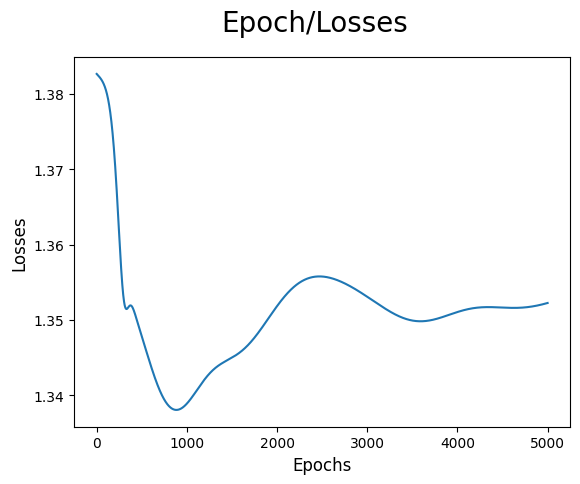

In [24]:
ix = np.arange(0,5000)
fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[costs[i] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [25]:
# test
x_test = np.arange(vocab_size)
x_test = np.expand_dims(x_test, axis=0)
softmax_test, _ = forward(x_test, params)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

for input_ind in range(vocab_size):
 input_word = id_to_word[input_ind]
 output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1,
 input_ind]]
 print("{}'s skip-grams: {}".format(input_word, output_words))


طالب's skip-grams: ['البرلمانية', 'نواب', 'طالب', 'المعارضة']
نواب's skip-grams: ['البرلمانية', 'طالب', 'نواب', 'المعارضة']
المعارضة's skip-grams: ['البرلمانية', 'طالب', 'نواب', 'المعارضة']
البرلمانية's skip-grams: ['المعارضة', 'نواب', 'طالب', 'البرلمانية']


### VII - Glove 

In [26]:
# create the dict.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
# number of unique words in dict.
print("Number of unique words in dictionary=",
len(tokenizer.word_index))
print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 4
Dictionary is =  {'طالب': 1, 'نواب': 2, 'المعارضة': 3, 'البرلمانية': 4}


In [29]:
def embedding_for_vocab(filepath, word_index,
embedding_dim):
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [31]:
# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab( 'glove.txt', tokenizer.word_index,embedding_dim)
print("Dense vector for first word is => ",embedding_matrix_vocab[1])

Dense vector for first word is =>  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


### VIII - FastText

In [48]:
# Train FastText model on the filtered words
model = FastText(sentences=[filtered_words], min_count=1)

In [36]:
# Function to get word vector
def get_word_vector(word):
    # Check if word exists in vocabulary
    if word in model.wv.key_to_index:
        return model.wv[word]
    else:
        char_vectors = [model.wv[char] for char in word]
        return sum(char_vectors) / len(char_vectors)

In [50]:
#Example usage
word = "الاقتصاديه" 
word_vector = get_word_vector(word)
print("Word vector for", word, ":", word_vector)

# Find similar words
similar_words = model.wv.most_similar(positive=[word], topn=2)
print("Similar words to", word, ":", similar_words)

Word vector for الاقتصاديه : [-6.5351621e-04  1.8229700e-03 -1.0646904e-03 -2.6359770e-04
  5.6904735e-04 -2.4271637e-04  2.5121635e-04 -7.2292623e-04
  1.2045397e-03  4.7594117e-04 -2.4737706e-03  1.5155604e-03
 -1.5856129e-03  6.3928706e-04 -2.3683302e-04 -1.0827454e-03
 -1.4560886e-04  2.4498443e-04  1.5830515e-03  8.3135848e-04
  2.0894940e-05 -3.9701862e-04  1.9382261e-04  4.4357218e-04
 -6.7095197e-04 -7.5373129e-04 -1.4037814e-03  1.1133315e-03
 -1.0319415e-03  1.2119008e-03 -2.9401027e-04  5.1886524e-04
  7.3067880e-05 -2.2689765e-03 -2.2619083e-03  1.0394169e-03
 -7.5846416e-04  3.6818851e-04  2.1003552e-03 -2.4866100e-04
  6.7537396e-05 -1.1395260e-04  9.9369709e-04  3.8186851e-04
 -9.0902543e-04  4.2532268e-04  1.1351197e-03 -1.8195057e-03
 -8.7684940e-04 -9.6625218e-04  1.8822394e-03 -7.5736846e-04
 -2.7264361e-04 -2.2117318e-04 -4.6593217e-05 -1.7930336e-04
 -1.4429260e-03 -1.0863669e-03  9.5430610e-04  8.7219890e-04
 -2.0246897e-03  1.0871929e-03  4.0253456e-04 -3.0654547

### IV - Visualization

In [46]:
# One-Hot Encoding
one_hot_encoded = OneHotEncoder(filtered_sen[0])
one_hot_matrix = np.array(one_hot_encoded)

# BoW (Bag-of-Words)
bow_matrix = BOW.toarray()

# TF-IDF
tfidf_matrix = tfidf_matrix.toarray()

# FastText
fasttext_matrix = np.array([model.wv[token] for token in custom_tokens])


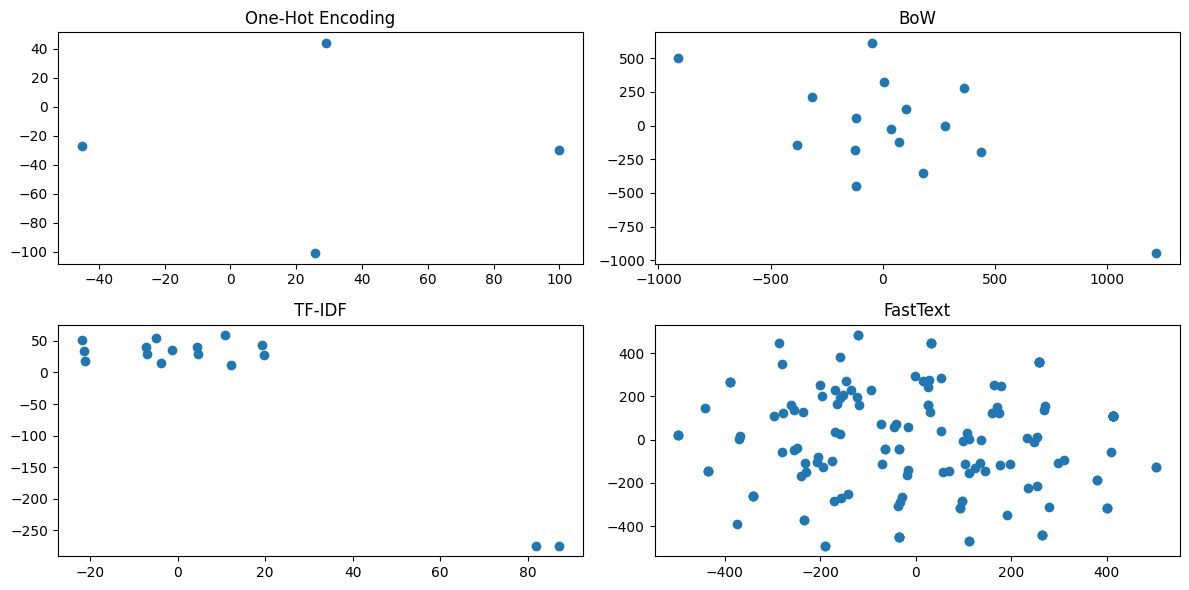

In [47]:
#Apply t-SNE to each vectorization method
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
tsne = TSNE(n_components=2, random_state=42,perplexity = 1)
one_hot_tsne = tsne.fit_transform(one_hot_matrix)
plt.scatter(one_hot_tsne[:, 0], one_hot_tsne[:, 1])
plt.title("One-Hot Encoding")

plt.subplot(2, 2, 2)
bow_tsne = tsne.fit_transform(bow_matrix)
plt.scatter(bow_tsne[:, 0], bow_tsne[:, 1])
plt.title("BoW")

plt.subplot(2, 2, 3)
tfidf_tsne = tsne.fit_transform(tfidf_matrix)
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1])
plt.title("TF-IDF")

plt.subplot(2, 2, 4)
fasttext_tsne = tsne.fit_transform(fasttext_matrix)
plt.scatter(fasttext_tsne[:, 0], fasttext_tsne[:, 1])
plt.title("FastText")

plt.tight_layout()
plt.show()

### Conclusion :

In summary, my reflections from this lab underscore the intricacies inherent in Arabic, surpassing those of its Latin counterparts. The exercise has equipped me with strategies for discerning patterns among words and discerning similarities between them. Moreover, the exploration revealed a significant research gap in Arabic NLP, resulting in a paucity of available libraries tailored to Arabic text processing, thereby posing challenges to practitioners seeking comprehensive tools in this domain.

### References :

##### [1] Jeet. (2021, December 15). One Hot encoding of text data in Natural Language Processing. Medium. https://medium.com/analytics-vidhya/one-hot-encoding-of-text-data-in-natural-language-processing-2242fefb2148
##### [2] | notebook.community. (n.d.). https://notebook.community/arcyfelix/Courses/18-03-07-Deep%20Learning%20With%20Python%20by%20Fran%C3%A7ois%20Chollet/.ipynb_checkpoints/Chapter%206.1.1%20-%20One-hot%20encoding%20of%20words%20and%20characters-checkpoint
##### [3] Munther, I. (2021, December 30). Sentiment Analysis of Arabic Text Data (Tweets) - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/sentiment-analysis-of-arabic-text-data-tweets-4e96c8da892b
##### [4] freeCodeCamp.org. (2019, July 24). How to process textual data using TF-IDF in Python. https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/
##### [5] GeeksforGeeks. (2024, January 3). Word Embedding using Word2Vec. GeeksforGeeks. https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/
